# Object Detection System

## 개요

### 실습 목표

1. Object detection 모델을 학습할 수 있습니다.
2. RetinaNet 모델을 활용한 시스템을 만들 수 있습니다.

### 학습 내용

1. 자율주행 보조장치
2. RetinaNet
3. 데이터 준비부터 모델 학습, 결과 확인까지
4. 프로젝트: 자율주행 보조 시스템 만들기

## KITTI dataset

* 자율 주행 보조장치 Object Detection 요구사항
1. 사람이 카메라에 감지되면 정지
2. 차량이 일정 크기 이상으로 감지되면 정지
* KITTI dataset은 자율 주행을 위한 dataset, 2D object detection 뿐 아니라 깊이를 포함한 3D object detection 라벨 등을 제공.

### 라이브러리 불러오기

In [1]:
import copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = 'data'

### Dataset 다운로드

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

2022-10-04 10:59:16.304574: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/6347 [00:00<?, ? examples/s]

2022-10-04 11:49:00.080424: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-04 11:49:00.574547: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 568 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


Shuffling data/kitti/3.2.0.incomplete927EH0/kitti-train.tfrecord*...:   0%|          | 0/6347 [00:00<?, ? exam…

Generating validation examples...:   0%|          | 0/423 [00:00<?, ? examples/s]

Shuffling data/kitti/3.2.0.incomplete927EH0/kitti-validation.tfrecord*...:   0%|          | 0/423 [00:00<?, ? …

Generating test examples...:   0%|          | 0/711 [00:00<?, ? examples/s]

Shuffling data/kitti/3.2.0.incomplete927EH0/kitti-test.tfrecord*...:   0%|          | 0/711 [00:00<?, ? exampl…

Dataset kitti downloaded and prepared to data/kitti/3.2.0. Subsequent calls will reuse this data.


### Data 확인

* ds_info : 불러온 dataset의 정보를 확인

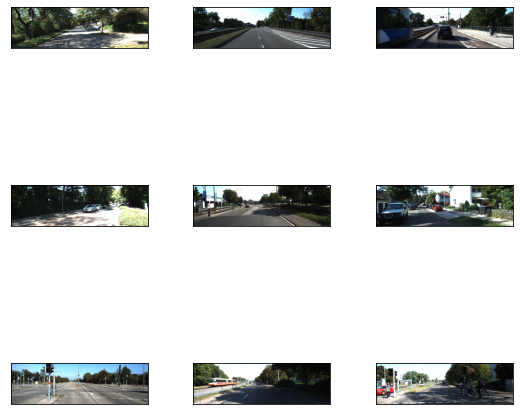

In [3]:
_ = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/tmp/tmpwpe0mo_etfds',
    file_format=tfrecord,
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
       

* train : 6347개
* test : 711개
* validation : 423개 

## 데이터 직접 확인하기

* ds_train.take(1) : train 데이터셋에서 하나씩 sample을 얻을 수 있음

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([ 1.73,  1.66,  1.62,  1.87, -1.57], dtype=float32)>, 'bbox': <tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0.36106667, 0.35565218, 0.52261335, 0.4184058 ],
       [0.45472   , 0.43326086, 0.52085334, 0.45800322],
       [0.48216   , 0.4578905 , 0.52184   , 0.47069243],
       [0.47690666, 0.3054509 , 0.5327733 , 0.32899356],
       [0.41762668, 0.47487924, 0.53      , 0.5089452 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[1.52, 1.55, 3.79],
       [1.48, 1.62, 3.21],
       [1.55, 1.51, 3.75],
       [1.92, 1.58, 3.93],
       [1.62, 1.63, 4.5 ]], dtype=float32)>, 'location': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-3.570e+00,  1.710e+00,  2.024e+01],
       [-3.520e+00,  1.910e+00,  4.503e+01],
       [-3.580e+00,  2.250e+00,  7.770e+01],
       [-2.058e+01,  2.170e+00,  6.8

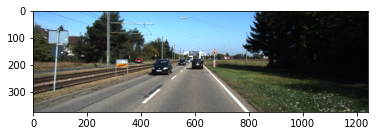

In [5]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

* 이미지와 라벨을 얻음.
* 이미지의 bounding box(bbox) 확인

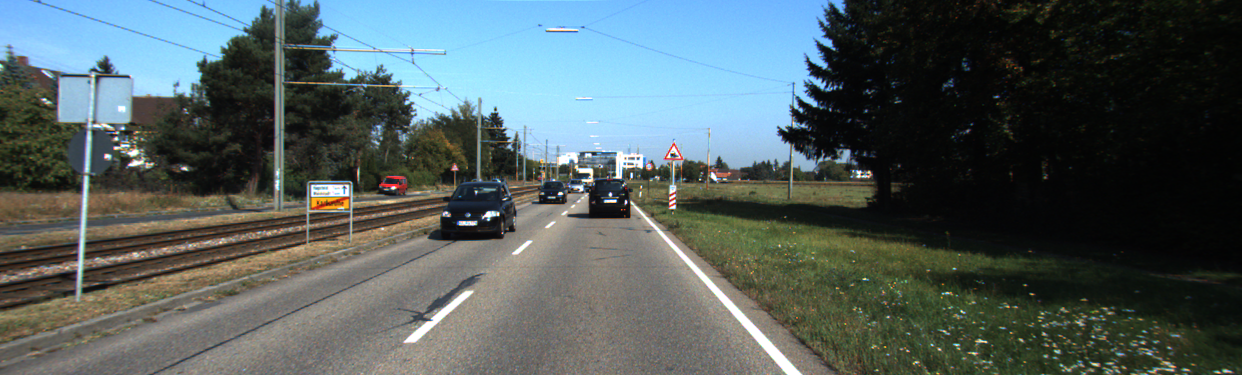

In [7]:
img

In [11]:
bbox = objects['bbox'].numpy()
display(bbox)
# bounding box의 개수
len(bbox)

array([[0.36106667, 0.35565218, 0.52261335, 0.4184058 ],
       [0.45472   , 0.43326086, 0.52085334, 0.45800322],
       [0.48216   , 0.4578905 , 0.52184   , 0.47069243],
       [0.47690666, 0.3054509 , 0.5327733 , 0.32899356],
       [0.41762668, 0.47487924, 0.53      , 0.5089452 ]], dtype=float32)

5

width = 1242  height =  375
441.72001165151596 239.59999904036522 519.6600049138069 179.019995033741

538.1099857091904 204.48000356554985 568.8400028944016 179.6799972653389

568.7000141143799 194.18999925255775 584.5999930500984 179.31000888347626

379.37000101804733 196.16000354290009 408.6100001335144 175.21000653505325

589.800009906292 218.38999539613724 632.1099715232849 176.25001072883606



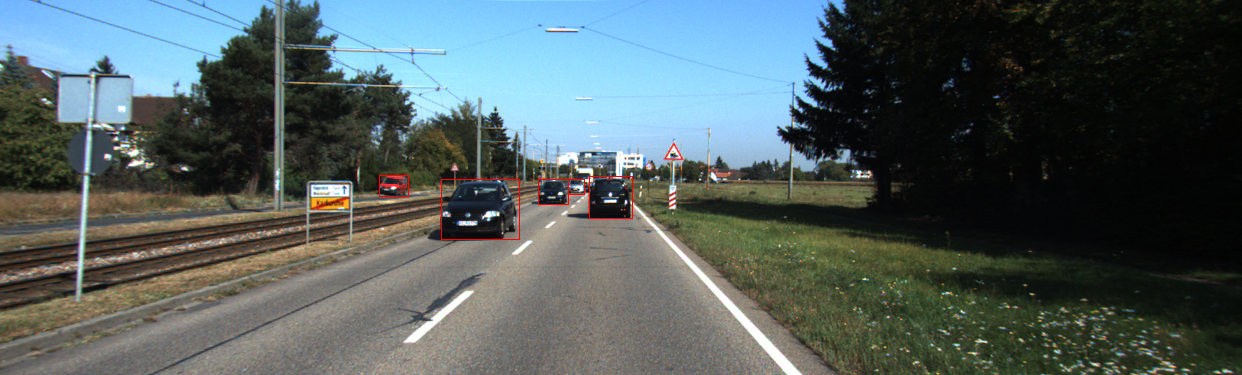

In [39]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    # bounding box의 좌표는 원래 이미지의 비례값만 가지고 있기 때문에 정확한 위치값을 구하는 정보가 필요합니다.
    width, height = input_image.size
    print('width =', width, ' height = ', height)
    # box는 이미지상에서 좌측 상단부터의 비율을 나타냅니다.
    # box = [y_min, x_min, y_max, x_max] 순서로 있습니다.
    for box in object_bbox:
        x_min = box[1] * width
        y_min = height - box[0] * height
        x_max = box[3] * width
        y_max = height - box[2] * height
        
        print(x_min,y_min,x_max,y_max)
        print()
        
        # 여기서 좌표는 좌측하단에서부터의 위치이므로 x좌표는 동일하나
        # y 좌표는 높이에서 빼줘야 합니다.
        draw.rectangle([x_min,y_min,x_max,y_max], outline = (255,0,0))
    
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

## RetinaNet 

* one stage detector는 two stage detector 보다 더 빠르지만 성능이 더 낮은 단점이 있습니다.
* 이를 극복하기 위해 focal loss와 FPN(Feature Pyramid Network)를 적용한 네트워크를 사용합니다.

### Focal Loss

* 배경보다 물체를 더 학습을 잘하자 = 물체의 경우 loss를 작게 만들자
* 보통 우리의 모델은 물체보다는 배경을 많이 학습하게 됩니다.
* 여기서 loss를 개선해서 정확도를 높입니다.

* Cross-Entropy를 기반으로 만들어짐.
* $CE(p_{t})$ 의 앞단에 $(1-p_{t})^{\gamma}$ 라는 modulating factor를 붙여줌
* $CE(p_{t}) = -log(p_{t})$
* $FL(p_{t}) = -(1-p_{t})^{\gamma} log(p_{t})$
* $\gamma$가 0이 되면 modulating facotr 가 1이 되어 일반적인 교차 엔트로피 $$

### FPN(Feature Pyramid Network)

* 특성을 피라미드처럼 쌓아서 사용하는 방식.
* 백본의 여러 레이어를 한꺼번에 쓰겠다라는데 의의

## 데이터 준비

### 데이터 파이프라인